# Segundo Trabalho de Introdução à Computação Visual

Rita Rezende Borges de Lima<br>
2020065317

In [1]:
!pip3 install -r requirements.txt

In [2]:
import cv2

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import Image
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *

from calibration_values import FOCAL_LENGTH_X, FOCAL_LENGTH_Y, PRINCIPAL_POINT_X, PRINCIPAL_POINT_Y, DIST_COEFFS
from objloader import *


pygame 2.1.3.dev4 (SDL 2.0.20, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Calibração da Câmera

Inicialmente o vídeo passado como entrada foi convertido em uma sequência de imagens utilizando o seguinte [site](https://ezgif.com/video-to-jpg). Os parâmetros de calibração intrínsecos foram obtidos utilizando um dos [toolbox passados em aula](https://github.com/nghiaho12/camera_calibration_toolbox_octave) rodado no __Octave__ versão 5.2.0. Estes foram guardados no arquivo ```calibration_values.py``` que serão lidos em seguida. 

In [3]:
m_int =  np.array([[FOCAL_LENGTH_X, 0.            , PRINCIPAL_POINT_X],
                  [  0.           , FOCAL_LENGTH_Y, PRINCIPAL_POINT_Y],
                  [  0.           , 0.            , 1.               ]])
dist = np.array(DIST_COEFFS)

## Leitura de Entradas

Inicialmente vamos ler as entradas passadas na especificação. Estas constituem de um alvo passado no formato jpg e um vídeo em formato mp4. O primeiro será buscado dentro do último.

O alvo será lido com a função ```imread()``` e binarizado com a função ```threshold()``` da biblioteca __openCV__. O alvo pode ser visto abaixo:

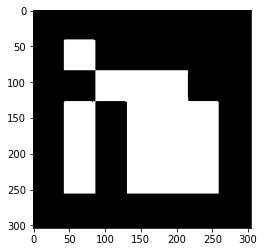

In [4]:
target = cv2.imread('alvo.jpg', cv2.IMREAD_GRAYSCALE)
ret, target = cv2.threshold(target, 128, 255, cv2.THRESH_BINARY)

plt.imshow(target, cmap='gray')
plt.show()

O vídeo será lido com a função ```VideoCapture()``` da biblioteca __openCV__.

In [5]:
video = cv2.VideoCapture('entrada.mp4')

## Detecção do Alvo

Abaixo serão implementadas as funções de detecção do alvo em um frame especifico. Todas foram implementadas utilizando a biblioteca __openCV__. Futuramente serão chamadas no processamento do video, mas para facilidade de teste abaixo serão mostradas funcionando com uma das imagens utilizadas para calibração como entrada.

In [6]:
example_img = cv2.imread('./images/Image2.jpg', cv2.IMREAD_GRAYSCALE)

### Binarização da Imagem

A imagem agora terá apenas dois valores de pixel, preto e branco, para isso foi utilizada a função ```threshold()``` e o parâmetro limite foi o teto da divisão de $\frac{255}{2}$ que por sua vez é igual a  $128$.

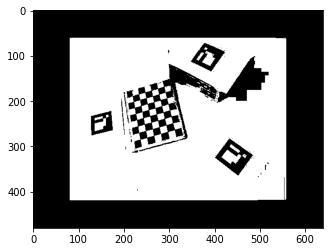

In [7]:
def make_frame_binary(img):
    ret, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    return img

binary_img = make_frame_binary(example_img)
plt.imshow(binary_img, cmap='gray')
plt.show()

### Busca por Bordas

Com a função ```findContours()``` da __openCV__ é possível obter bordas da imagem já binarizada. Para isso passamos os parâmetros RETR_LIST de modo que todos os contornos da aplicação sejam retornados sem uma ordem particular e CHAIN_APROX_SIMPLE que retorna apenas os vértices do contorno. Mais detalhes da função podem ser encontrados [aqui](https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html). A função implementada ```find_contours()``` busca retorna todos os contornos encontrados e a imagem com esses em destaque caso o parâmetro opcional ```plot_img``` tenha valor positivo.

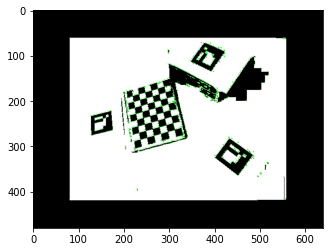

In [8]:
def find_contours(img, plot_img = False):
    
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if plot_img:
        img2 = cv2.merge((img,img,img))  
        for c in contours:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.04 * peri, True)
            for pos in c:
                x = pos[0][1] - 1; y = pos[0][0] - 1
                img2[x][y] = [0, 255, 0]
    
        plt.imshow(img2, cmap='gray')

    return contours


contours = find_contours(binary_img, plot_img = True)
plt.show()  

### Busca por Polígonos de Quatro Lados

A lógica para encontrar os quadrados foi baseada no seguinte [tutorial](https://pyimagesearch.com/2016/02/08/opencv-shape-detection/) e no seguinte [post do stack overflow](https://stackoverflow.com/questions/60178004/what-is-the-result-of-arclength-for-a-contour). A função implementada ```find_rhombus()``` busca por polígonos de 4 vértices que possuam área mínima e máxima especificada por parâmetros. Ela retorna os quadrados que possivelmente possuem alvos e a imagem com esses em destaque caso o parâmetro opcional ```plot_img``` tenha valor positivo.

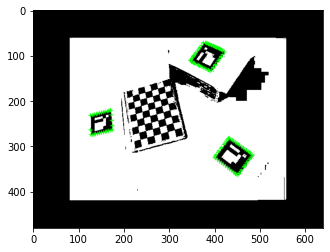

In [9]:
def find_rhombi(img, contours, plot_img = False, n_of_vertices = 4, min_area = 400):
    
    max_area = img.shape[0] *img.shape[1]/2
    rhombi = []
    img2 = cv2.merge((img,img,img))  # creat RGB image from grayscale    

    for c in contours:

        approx = cv2.approxPolyDP(c, 0.04 * cv2.arcLength(c, True), True)        
        if(len(approx) == n_of_vertices and cv2.contourArea(approx) > min_area and cv2.contourArea(approx) < max_area): 
            rhombi.append(approx.reshape(-1, 2))
            
            if plot_img:
                
                for pos in c:
                    x = pos[0][1] - 1; y = pos[0][0] - 1
                    
                    x_i = x
                    while(x_i > 0 and x_i > x-5):
                        img2[x_i][y] = [0, 255, 0]
                        x_i -= 1
                        
                    x_i = x
                    while(x_i < img.shape[0] and x_i < x + 5):
                        img2[x_i][y] = [0, 255, 0]
                        x_i += 1
                        
                    y_i = y
                    while(y_i > 0 and y_i > y-5):
                        img2[x][y_i] = [0, 255, 0]
                        y_i -= 1
                        
                    y_i = y
                    while(y_i < img.shape[1] and y_i < y + 5):
                        img2[x][y_i] = [0, 255, 0]
                        y_i += 1
            
    if plot_img:
        plt.imshow(img2, cmap='gray')

            
    return np.array(rhombi)


rhombi = find_rhombi(binary_img, contours, plot_img = True)

### Busca por Alvo com Homografia

Para a compararmos o alvo com os polígonos de quatro lados detectados no vídeo é necessário retificar estes, para isso foi criada a função ```rhombus_rectification()```, esta recebe como parâmetro a imagem binária com os losângos que serão retificados, os polígonos e um parâmetro opcional que define se o resultado será impresso na tela. É utilizada função ```findHomography()``` da __openCV__ conforme visto neste [tutorial](https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html) <br>
 utilizando o método CV_RANSAC que é robusto ao tratar com outliers. Tendo a homografia podemos chamar a função ```warpPerspective()```, implementada utilizando a seguinte [fonte](https://pyimagesearch.com/2014/05/05/building-pokedex-python-opencv-perspective-warping-step-5-6/) que irá retornar nosso possível alvo retificado.

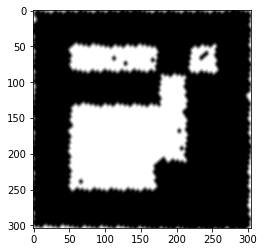

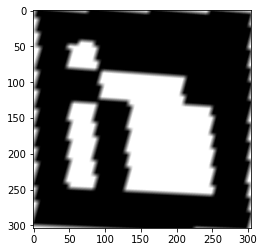

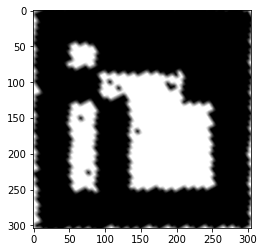

In [10]:
def rhombus_rectification(img, rhombi, plot_img = False): 
    
    warps = []
    for r in rhombi:
        h, w = target.shape
        M, mask = cv2.findHomography(r, np.array([[0,0], [w-1, 0], [w-1, h-1], [0, h-1]]), cv2.RANSAC, 5.0)
        warp = cv2.warpPerspective(img, M, (w, h), flags=cv2.INTER_LINEAR)  
        warps.append(warp)
        
        if plot_img:
            plt.imshow(warp, cmap='gray')
            plt.show() 
        
    return warps

squares = rhombus_rectification(binary_img, rhombi, plot_img = True)

### Detectando Orientação do Alvo

A função de erro ```mse```, do inglês Mean Squared Error foi retirada do seguinte [tutorial](https://pyimagesearch.com/2014/09/15/python-compare-two-images/). A rotação dos quadrados foi realizada baseada na seguinte [fonte](https://learnopencv.com/image-rotation-and-translation-using-opencv/). Para isso utilizamos a função ```getRotationMatrix2D()``` para cada uma das 4 rotações possíveis para um quadrado. Fazemos a transformação afim e comparamos com nosso target para encontrar a rotação correta.

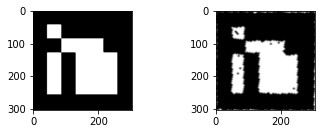

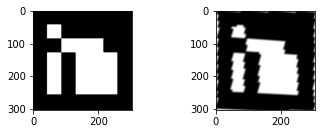

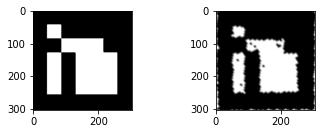

In [11]:
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])*256

    return err
    
   
    
def find_rotation(original_rhombi, rectified_squares, lim = 20, plot_img = False):
    correct_squares = []; correct_rotations = []
    for idx, square in enumerate(original_rhombi):
        width, height = rectified_squares[idx].shape
        for angle in [0, 90, 180, 270]:
            rotate_matrix = cv2.getRotationMatrix2D((height/2, width/2), angle, 1)
            rotated_square = cv2.warpAffine(rectified_squares[idx], rotate_matrix, (width, height))
            if mse(rotated_square, target) < lim:
                correct_squares.append(square); correct_rotations.append(angle)
                if plot_img:
                    fig = plt.figure()
                    ax1 = fig.add_subplot(2,2,1)
                    ax1.imshow(target, cmap='gray')
                    ax2 = fig.add_subplot(2,2,2)
                    ax2.imshow(rotated_square, cmap='gray')
                    plt.show() 
                
    return correct_squares, correct_rotations

correct_squares, correct_rotations = find_rotation(rhombi, squares, plot_img = True)

## Obtendo a Pose da Câmera

De pose da orientação resta estimar a posição, para isso foram utilizados os seguinte [tutorial da OpenCV](https://docs.opencv.org/4.x/d7/d53/tutorial_py_pose.html), os slide de aula. Por fim a compreensão da função ```solvePnP()``` vem [daqui](https://www.pythonpool.com/opencv-solvepnp/#:~:text=OpenCV%20solvePnP%20is%20mainly%20used,activity%20by%20observing%20their%20gestures.). A função auxiliar ```get_image_points()``` rotaciona os pontos do objeto em função do angulo recebido.

In [12]:
def get_image_points(src_points, angle):
    return {
          0: np.array([src_points[0], src_points[1], src_points[2], src_points[3]], dtype = float),
         90: np.array([src_points[3], src_points[0], src_points[1], src_points[2]], dtype = float),
        180: np.array([src_points[2], src_points[3], src_points[0], src_points[1]], dtype = float),
        270: np.array([src_points[1], src_points[2], src_points[3], src_points[0]], dtype = float)
    }[angle]
    

def find_poses(obj_points, square, correct_rotation, plot_img = False):
    img_points = get_image_points(np.flip(square, 0), correct_rotation)

    return cv2.solvePnP(obj_points, img_points, m_int, dist)

obj_points = np.float32([[1,1,0], [3,1,0], [3,3,0], [1,3,0]])
_, rvec, tvec = find_poses(obj_points, correct_squares[0], correct_rotations[0], plot_img = True)
rvec, tvec

(array([[ 1.15712098],
        [ 2.55274084],
        [-0.72784865]]),
 array([[ 3.99380394],
        [ 0.4984494 ],
        [14.49574159]]))

In [13]:
def get_view_matrix(rvec, tvec):
    
    view_matrix = np.zeros((4, 4), dtype=float)   
    rotation, _ = cv2.Rodrigues(rvec)

    for row in range(3):        
        for col in range(3):
            view_matrix[row][col] = rotation[row][col]
            
        view_matrix[row][3] = tvec[row][0]
    view_matrix[3][3] = 1.0
    
    return view_matrix

view_matrix = get_view_matrix(rvec, tvec)
view_matrix

array([[-0.65537089,  0.75512222,  0.01671629,  3.99380394],
       [ 0.63276058,  0.56098923, -0.53376505,  0.4984494 ],
       [-0.41243551, -0.33923667, -0.84546758, 14.49574159],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## Renderização com OpenGL

### Inicialização com Parâmetros Intrínsecos de Câmera

lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd lorem ipsum dolem asdblasd

In [14]:
def initOpenGL(dimensions):

    (width, height) = dimensions
    
    glClearColor(0.0, 0.0, 0.0, 0.0)
    glClearDepth(1.0)

    glEnable(GL_DEPTH_TEST)
    
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    
    fx = m_int[0][0]
    fy = m_int[1][1]
    fovy = 2*np.arctan(0.5*height/fy)*180/np.pi
    aspect = (width*fy)/(height*fx)
    
    near = 0.1
    far = 100.0

    gluPerspective(fovy, aspect, near, far);
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()

### Renderização de Elementos da Cena

chama ```renders_background()``` e ```renders_cube()``` para renderizar os frames do vídeo de entrada e do cubo e do pikachu.

In [15]:
def displayCallback():
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
    
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)

    obj = OBJ("Pikachu.obj", swapyz=True)    
    
    read, frame = video.read()
    
    renders_background(frame, video_texture_id = glGenTextures(1))
    renders_cube(frame, obj)

    
    glFlush()    
    glutSwapBuffers()  

### Renderização de cada Frame do Vídeo

lorem lorem lorem lorem lorem

In [16]:
def orthogonal_start(width, height) :

    glMatrixMode(GL_PROJECTION)
    glPushMatrix()
    glLoadIdentity()
    gluOrtho2D(-width/2, width/2, -height/2, height/2)


def orthogonal_end(width, height):

    glMatrixMode(GL_PROJECTION)
    glPopMatrix()
    glMatrixMode(GL_MODELVIEW)
    
    
# Renderiza imagem no fundo do objeto 
def renders_background(frame, video_texture_id):

    glEnable(GL_TEXTURE_2D)

    glBindTexture(GL_TEXTURE_2D, video_texture_id)
    
    converted_img = cv2.flip(frame, 0)
    converted_img = cv2.cvtColor(converted_img, cv2.COLOR_BGR2RGB)
    height, width, n_of_channels = converted_img.shape    

    glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, width, height, 0, GL_RGB, GL_UNSIGNED_BYTE, converted_img)    

    
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_NEAREST)
    glTexParameterf(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_NEAREST)
    glDepthMask(GL_FALSE)
    
    glMatrixMode(GL_MODELVIEW)
    glLoadIdentity()
        
    orthogonal_start(width, height)
    
    glPushMatrix()
    glTranslatef(-width/2, -height/2, 0)
    glBegin(GL_QUADS)
    glTexCoord2f(0.0, 0.0); glVertex3f(0.0, 0.0, 0.0)
    glTexCoord2f(1.0, 0.0); glVertex3f(width, 0.0, 0.0)
    glTexCoord2f(1.0, 1.0); glVertex3f(width, height, 0.0)
    glTexCoord2f(0.0, 1.0); glVertex3f(0.0, height, 0.0)
    glEnd()
    glPopMatrix()
    
    orthogonal_end(width, height)
    
    glDepthMask(GL_TRUE)

### Renderização do Cubo e Pikachu

In [17]:
frame_number = 0

def object3D(obj, view_matrix):    
    
    inverse_matrix = np.array([[1.0,    0,    0,    0],
                              [  0, -1.0,    0,    0],
                              [  0,    0, -1.0,    0],
                              [  0,    0,    0,  1.0]], dtype=float)
    glPushMatrix();   
    view_matrix = (inverse_matrix @ view_matrix).T       
    glLoadMatrixd(view_matrix)

    # Renderiza um cubo
    glTranslate(2.0, 2.0, np.sqrt(3))
    glutWireCube(3.0)
    
    # Desenha as linhas que indicam a direção
    glBegin(GL_LINES)
    glVertex3f(1, 0, np.sqrt(3))
    glVertex3f(1, 3.5, np.sqrt(3))
    glEnd()
    
    #reta pra ponta direita da seta
    glBegin(GL_LINES)
    glVertex3f(1.5, 1.5, np.sqrt(3))
    glVertex3f(1.0, 3.5, np.sqrt(3))
    glEnd()
    
    #reta pra ponta esquerda da seta    
    glBegin(GL_LINES)
    glVertex3f(0.5, 2.5, np.sqrt(3))
    glVertex3f(1.0, 3.5, np.sqrt(3))
    glEnd()
    
    global frame_number
    frame_number += 1
    
    glRotate(frame_number, 0,0,1)    
    glTranslate(0,0,1)
    glCallList(obj.gl_list)
    
    glPopMatrix();
    


def renders_cube(frame, obj):
    
    bin_image = make_frame_binary(frame)
    gray_image = cv2.cvtColor(bin_image, cv2.COLOR_BGR2GRAY)

    contours = find_contours(gray_image, plot_img = False)
    rhombi = find_rhombi(gray_image, contours, plot_img = False)
    rectified_squares = rhombus_rectification(gray_image, rhombi, plot_img = False)
    correct_squares, correct_rotations = find_rotation(rhombi, rectified_squares, plot_img = False)   
    
    
    for idx, square in enumerate(correct_squares):

        cube_dims = np.array([[1,1,0], [3,1,0], [3,3,0], [1,3,0]], dtype=float)
        _, rvec, tvec = find_poses(cube_dims, square, correct_rotations[idx], plot_img = True)
        view_matrix = get_view_matrix(rvec, tvec)

        object3D(obj, view_matrix)

### MAIN

In [18]:
def idleCallback():
    glutPostRedisplay()
    
    
    
dimensions = (640, 480)
glutInit()
glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE)
glutSetOption(GLUT_ACTION_ON_WINDOW_CLOSE, GLUT_ACTION_CONTINUE_EXECUTION)
glutInitWindowSize(*dimensions)
window = glutCreateWindow(b'Realidade Aumentada [codigo esqueleto]')

initOpenGL(dimensions)

glutDisplayFunc(displayCallback)
glutIdleFunc(idleCallback)

glutMainLoop()